# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
import pickle
from matplotlib.colors import BoundaryNorm
import glob
import calendar
import warnings
warnings.filterwarnings('ignore')
import dask
import matplotlib.gridspec as gridspec

In [2]:
savedir = 'images/access/'

In [3]:
import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')

import phase_calc_functions as phase_calc
import phase_plot_functions as phase_plot
import subphase_calc_functions as subphase_calc
import access_functions as af
import access_plot_functions as apf

In [4]:
# This is the observed rmm
rmm = subphase_calc.load_rmm()
rmm

<xarray.Dataset>
Dimensions:    (time: 8340)
Coordinates:
  * time       (time) datetime64[ns] 1974-10-01 1974-10-02 ... 2020-02-16
Data variables:
    RMM1       (time) float64 0.5789 0.7589 0.8966 0.6736 ... 0.8362 1.284 1.449
    RMM2       (time) float64 -0.9097 -0.9504 -0.5804 ... 1.249 1.232 1.134
    phase      (time) float64 3.0 3.0 4.0 4.0 4.0 5.0 ... 6.0 6.0 6.0 5.0 5.0
    amplitude  (time) float64 1.078 1.216 1.068 0.7765 ... 1.235 1.503 1.78 1.84
Attributes:
    Months:   Values are only for the wet-season [10,11,12,1,2,3]

In [5]:
af = reload(af)
awap = af.load_awap()
awap

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, time: 19278)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time     (time) datetime64[ns] 1911-01-01 1911-01-02 ... 2017-12-31
Data variables:
    precip   (time, lat, lon) float32 nan 2.7694564 4.730564 ... nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

In [6]:
af = reload(af)
rmm_access = af.load_rmm_access()

In [7]:
rmm_access = rmm_access.where(rmm_access.time.dt.month.isin([10,11,12,1,2,3]), drop = True)
rmm_access

<xarray.Dataset>
Dimensions:    (ensemble: 11, time: 4192)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2012-12-31
Data variables:
    phase      (ensemble, time) float32 3.0 3.0 3.0 3.0 3.0 ... 7.0 7.0 7.0 7.0
    amplitude  (ensemble, time) float32 1.9151419 1.9850118 ... 1.3954009
Attributes:
    Info:     this is the 3rd version with atan2(rmm2, rmm2) (with no + 180)

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Matching </font></center></div>


In [8]:
af = reload(af)
access_directory = '/g/data/w40/ab2313/ACCESS_S_1ST_1M_ensembles/'
access = af.load_access(access_directory, chunks = 1)
access

<xarray.Dataset>
Dimensions:   (ensemble: 11, lat: 49, lon: 149, time: 8362)
Coordinates:
  * lat       (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time      (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2012-12-31
  * lon       (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    precip    (ensemble, time, lat, lon) float32 dask.array<chunksize=(1, 8362, 49, 149), meta=np.ndarray>
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...
    Time:         Only for the wet-season

In [9]:
'''First, both of the files must be of the same length'''

# Matching the two
awap = awap.where(awap.time.isin(access.time.values), drop = True)

access = access.where(access.time.isin(awap.time.values), drop = True)

In [10]:
len(access.time.values), len(awap.time.values)

(4159, 4159)

In [11]:
rmm_access = rmm_access.where(rmm_access.time.isin(access.time.values), drop = True)
access = access.where(access.time.isin(rmm_access.time.values), drop = True)

In [12]:
rmm = rmm.where(rmm.time.isin(rmm_access.time.values), drop = True)

In [13]:
len(rmm_access.time.values),len(rmm.time.values)

(4159, 4159)

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Splitting </font></center></div>


In [14]:
awap_split = phase_calc.split_into_1to8(awap, rmm)

# Percentile

## awap access matched

In [ ]:
awap_phase_mean = awap_split.groupby('phase').mean(dim = 'time')
awap_overall_mean = awap.mean(dim = 'time')
awap_mean_anomalies = awap_phase_mean/awap_overall_mean

In [ ]:
awap_overall_mean.precip.plot(cmap = 'Blues', vmin = 7, vmax = 18)

In [ ]:
phase_plot.values_plots(awap_phase_mean.precip, cbar_num_steps = 12,
             title = 'Rainfall Mean for Phases of the MJO (AWAP)', cbar_title = 'Mean Rainfall (mm)',
                       savefig = 0)

In [ ]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(awap_mean_anomalies.precip, vmax = 1.5, l1 = l1,
                cbar_title = 'Rainfall Ratio', title = 'Mean Rainfall Comparison in Phases of the MJO')

## ACCESS

### Single Ensemble Explore

In [ ]:
access_single = access.sel(ensemble = 2)
rmm_single = rmm_access.sel(ensemble = 2)

In [ ]:
access_split = phase_calc.split_into_1to8(access_single , rmm_single)

In [ ]:
access_phase_mean = access_split.groupby('phase').mean(dim = 'time')
access_overall_mean = access_single.mean(dim = 'time')
access_mean_anomalies = access_phase_mean/access_overall_mean

In [ ]:
phase_plot.values_plots(access_phase_mean.precip, cbar_num_steps = 12,
             title = 'Rainfall Mean for Phases of the MJO (ACCESS)', cbar_title = 'Mean Rainfall (mm)',
                       savefig = 0)

In [ ]:
access_mean_anomalies

In [ ]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(access_mean_anomalies.precip, vmax = 1.5, l1 = l1,
                cbar_title = 'Rainfall Ratio', title = 'ACCESS')

### All Ensembles

In [ ]:
ensemble_stor = []

# Itterating through all of the ensemble members
for ensemble in access.ensemble.values:
    # RMM and ACCESS for a single ensemble member (these functions don't seem to work for all the ensembles)
    access_single  = access.sel(ensemble = ensemble)
    rmm_single = rmm_access.sel(ensemble = ensemble)
    
    # Splitting into the different phases of the MJO
    access_single_split = phase_calc.split_into_1to8(access_single,rmm_single)
    
    
    access_single_mean = access_single_split.groupby('phase').mean(dim = 'time')
    # Storing for later concatination
    ensemble_stor.append(access_single_mean)
    
access_mean_phase = xr.concat(ensemble_stor, dim = 'ensemble').mean(dim = 'ensemble')

In [ ]:
access_single_mean

In [ ]:
phase_plot.values_plots(access_single_mean.precip, cbar_num_steps = 12,
             title = 'Rainfall Mean for Phases of the MJO (ACCESS-single_ensemble)',
                        cbar_title = 'Mean Rainfall (mm)')

In [ ]:
access_mean_phase

In [ ]:
phase_plot = reload(phase_plot)
phase_plot.values_plots(access_mean_phase.precip, cbar_num_steps = 12,
             title = 'Rainfall Mean for Phases of the MJO (AWAP)', cbar_title = 'Mean Rainfall (mm)',
                       savefig = 0)

In [ ]:
# The mean rainfall across all phases
access_mean_total = access.mean(dim = 'time').mean(dim = 'ensemble')

# The mean rainfall in each phase/ the mean rainfall for all phases
access_mean_anomalies = access_mean_phase/access_mean_total

access_mean_anomalies

In [ ]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(access_mean_anomalies.precip, vmax = 1.5, l1 = l1,
                cbar_title = 'Rainfall Ratio', title = 'Mean Rainfall Comparison in Phases of the MJO')

# Count

## AWAP

In [14]:
phase_calc = reload(phase_calc)

awap_split = phase_calc.split_into_1to8(awap, rmm)

awap_count_norm, awap_count_anomaly = phase_calc.count_and_anomly(awap_split, awap, rmm)

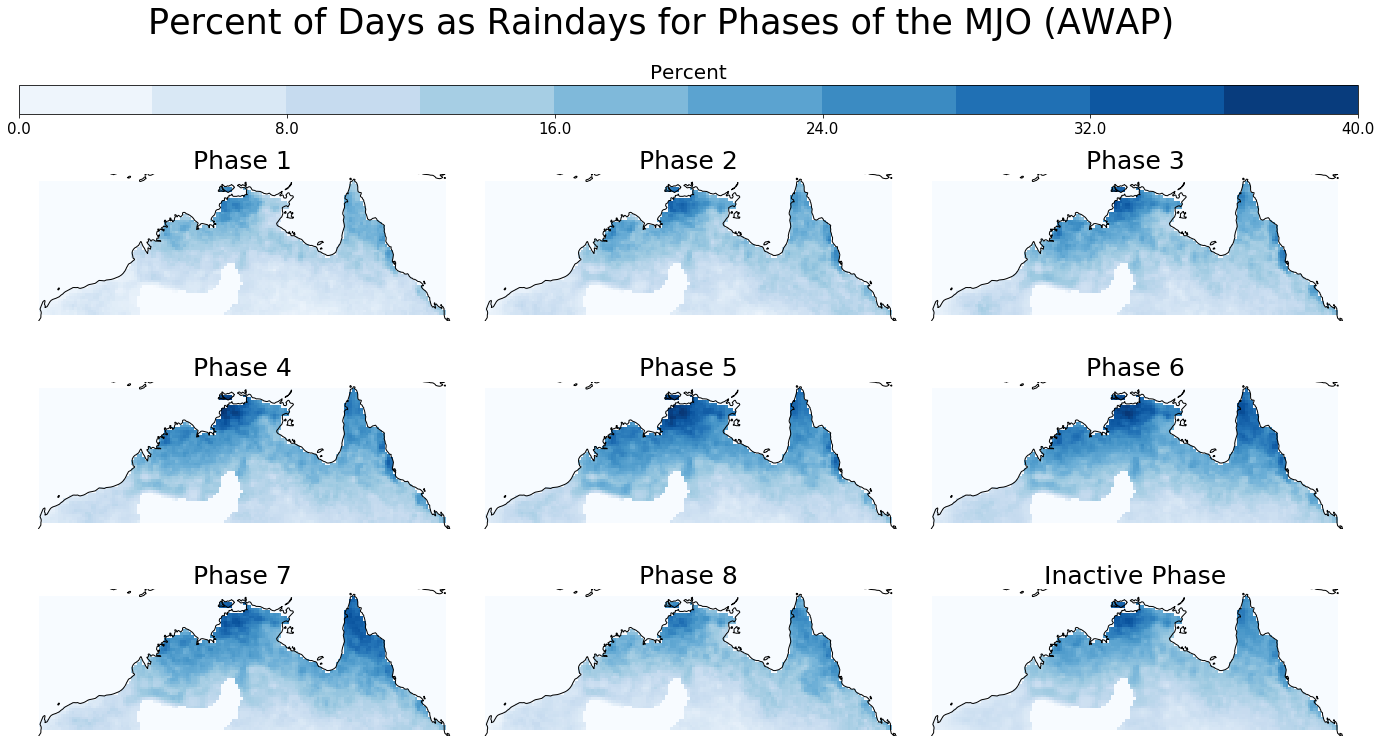

In [15]:
phase_plot = reload(phase_plot)
phase_plot.values_plots(awap_count_norm.precip, cbar_num_steps = 11,
             title = 'Percent of Days as Raindays for Phases of the MJO (AWAP) ', cbar_title = 'Percent',
                       savefig = 0,  savedir = savedir)

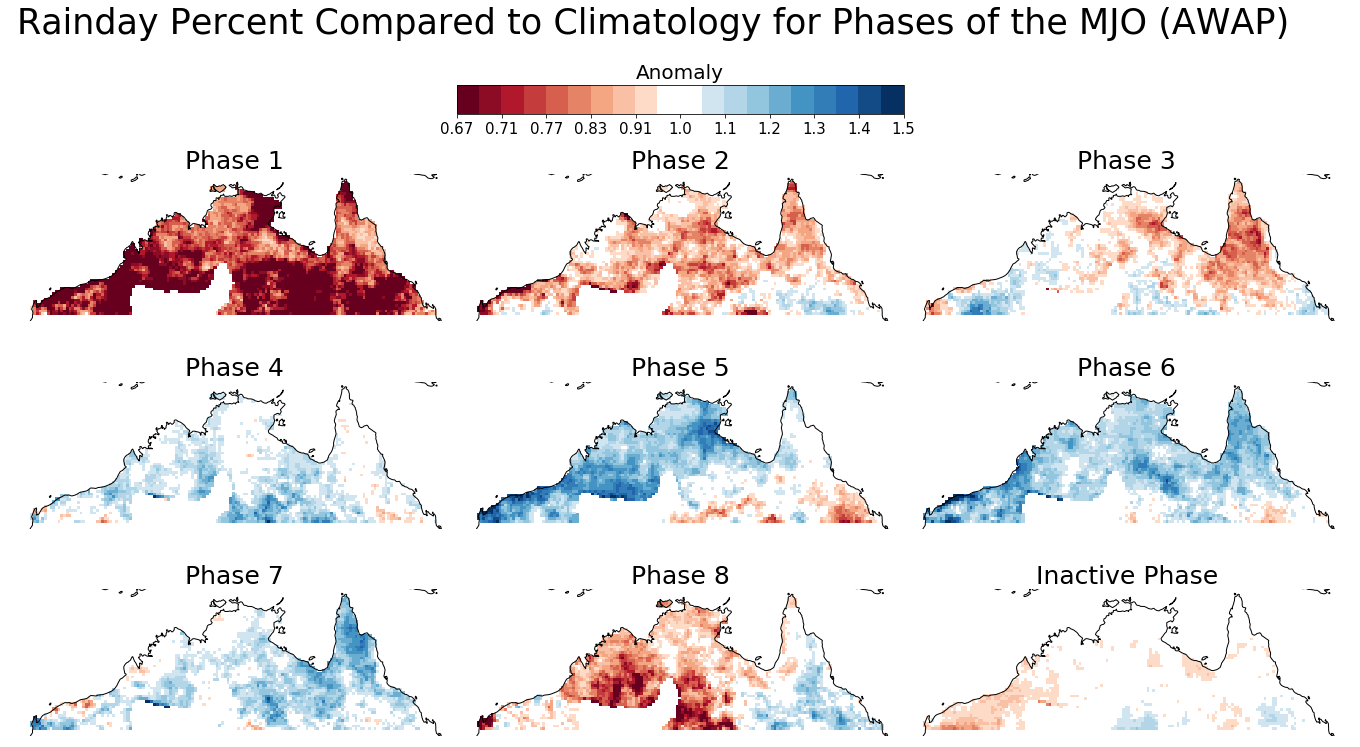

In [16]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(awap_count_anomaly.precip, vmax = 1.5, l1 = l1,           
             title = 'Rainday Percent Compared to Climatology for Phases of the MJO (AWAP) ', 
                           cbar_title = 'Anomaly',
                       savefig = 0, savedir = savedir)

## Single Ensemble

In [17]:
access_single = access.sel(ensemble = 2)
rmm_single = rmm_access.sel(ensemble = 2)

access_split = phase_calc.split_into_1to8(access_single, rmm_single)

phase_calc = reload(phase_calc)
access_count_norm_single, access_anomaly_norm_single = \
            phase_calc.count_and_anomly(access_split, access_single, rmm_single, calc_anomaly = 1)

In [18]:
access_count_norm_single

<xarray.Dataset>
Dimensions:   (lat: 49, lon: 149, phase: 9)
Coordinates:
    ensemble  int64 2
  * lat       (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon       (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * phase     (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
Data variables:
    precip    (phase, lat, lon) float64 dask.array<chunksize=(1, 49, 149), meta=np.ndarray>

In [19]:
access_count_norm_single = access_count_norm_single.compute()

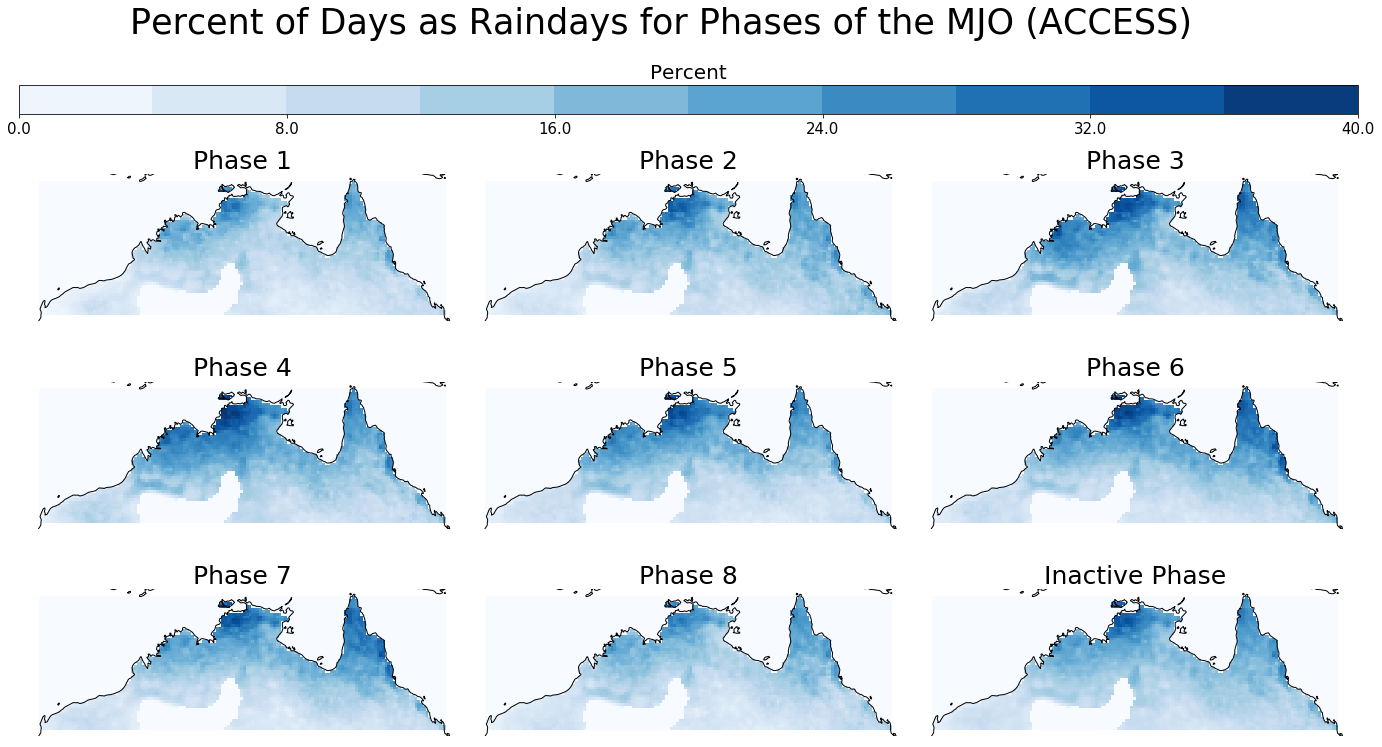

In [20]:
phase_plot = reload(phase_plot)
phase_plot.values_plots(access_count_norm_single.precip, cbar_num_steps = 11,
             title = 'Percent of Days as Raindays for Phases of the MJO (ACCESS) ', cbar_title = 'Percent')

In [21]:
access_anomaly_norm_single = access_anomaly_norm_single.compute()

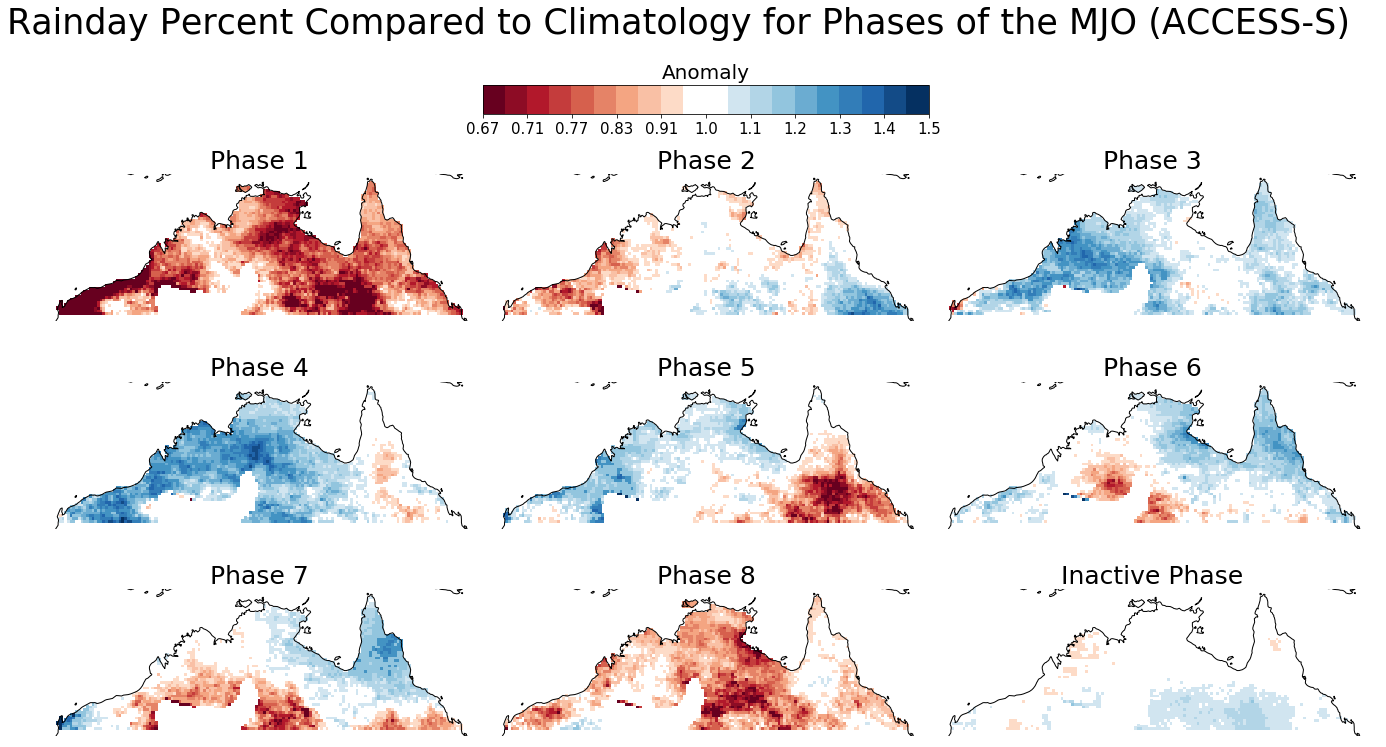

In [22]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(access_anomaly_norm_single.precip, vmax = 1.5, l1 = l1,           
             title = 'Rainday Percent Compared to Climatology for Phases of the MJO (ACCESS-S) ', 
                           cbar_title = 'Anomaly')

## All Ensemble 1

Looping through all fo the ensemble and calcualtes in the percent of days as raindays as well as how this compares to the climatology

In [23]:
phase_calc = reload(phase_calc)

count_stor = []
anom_stor = []
    
# Looping through ensemble
for ensemble in access.ensemble.values:
    
    # Selecting a single ensemble
    access_single = access.sel(ensemble = ensemble)
    rmm_single = rmm_access.sel(ensemble = ensemble)
    
    # Splitting the rainfall in to the 9 mjo phases
    access_split = phase_calc.split_into_1to8(access_single, rmm_single)
    
    # Calculating the index for a single ensemble
    access_count_norm_single, access_anomaly_norm_single = \
                phase_calc.count_and_anomly(access_split, access_single, rmm_single, calc_anomaly = 1)
    
    
    count_stor.append(access_count_norm_single)
    anom_stor.append(access_anomaly_norm_single)

    
    
# Storing all the results in a xarray files.
access_count_total = xr.concat(count_stor, dim = 'ensemble')
access_anom_total = xr.concat(anom_stor, dim = 'ensemble')

In [24]:
# Taking the mean across all ensembles

access_count_mean = access_count_total.mean(dim = 'ensemble').compute()

access_anom_mean = access_anom_total.mean(dim = 'ensemble').compute()

In [25]:
access_anom_mean

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9)
Coordinates:
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * lat      (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
Data variables:
    precip   (phase, lat, lon) float64 nan 0.5776 0.6053 0.6086 ... nan nan nan

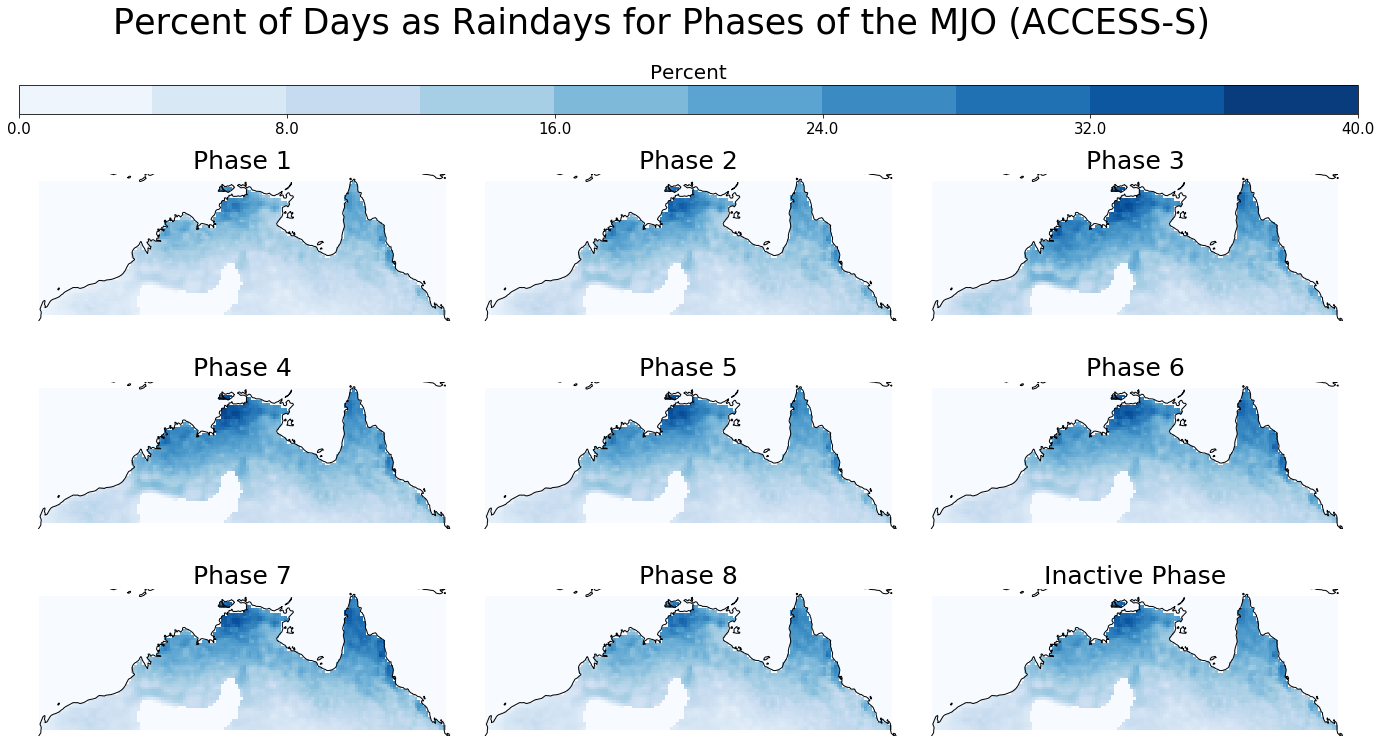

In [26]:
phase_plot = reload(phase_plot)
phase_plot.values_plots(access_count_mean.precip, cbar_num_steps = 11,
             title = 'Percent of Days as Raindays for Phases of the MJO (ACCESS-S) ', cbar_title = 'Percent', 
                       savedir = savedir, savefig = 0)

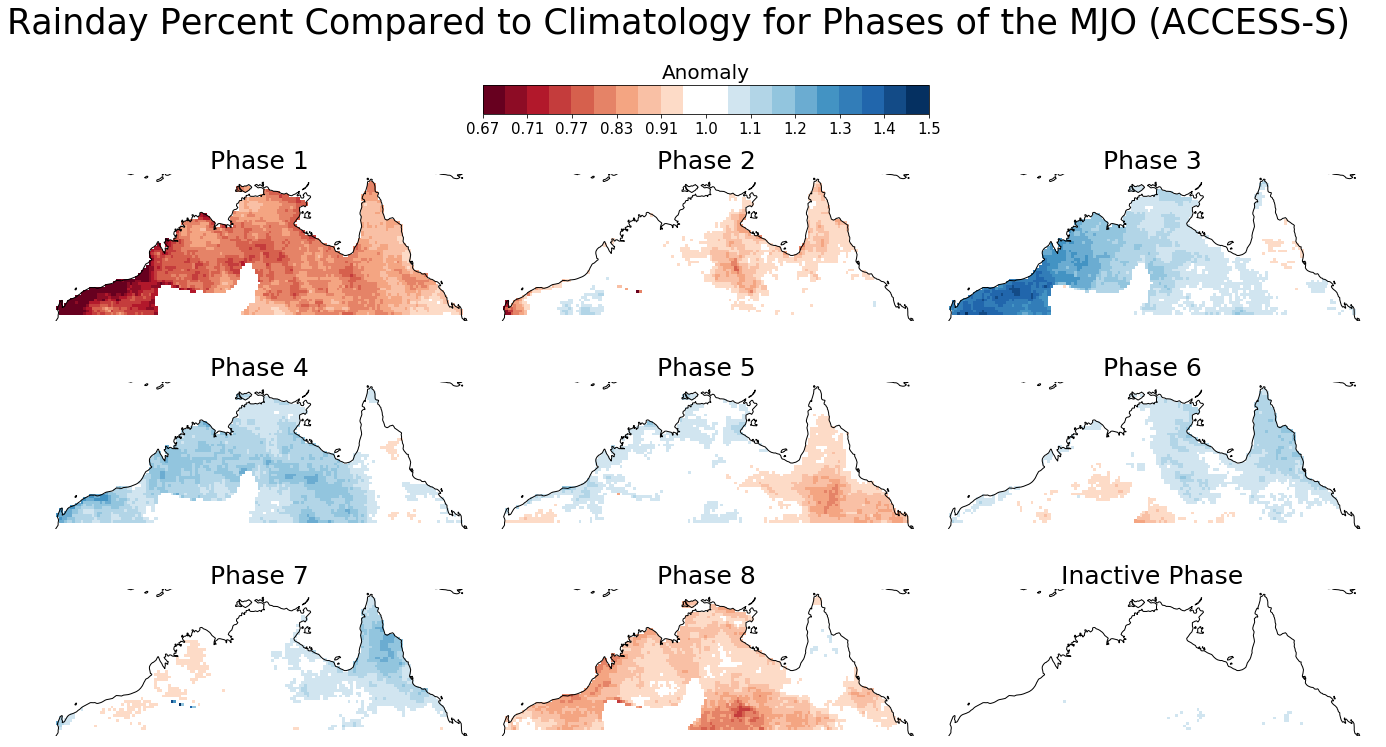

In [27]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(access_anom_mean.precip, vmax = 1.5, l1 = l1,           
             title = 'Rainday Percent Compared to Climatology for Phases of the MJO (ACCESS-S) ', 
                           cbar_title = 'Anomaly', 
                          savedir = savedir, savefig = 0)

## All Ensemble 2 (Defunked)

In [28]:
phase_calc = reload(phase_calc)

In [ ]:
access

In [ ]:
rmm_access

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> ACCESS Count </font></center></div>


Counting the numver of events in each phase for each ensemble, then taking the mean across all ensemble

In [ ]:
ensemble_stor = []

# Itterating through all of the ensemble members
for ensemble in access.ensemble.values:
    # RMM and ACCESS for a single ensemble member (these functions don't seem to work for all the ensembles)
    access_single  = access.sel(ensemble = ensemble)
    rmm_single = rmm_access.sel(ensemble = ensemble)
    
    # Splitting into the different phases of the MJO
    access_single_split = phase_calc.split_into_1to8(access_single,rmm_single)
    
    access_single_count = access_single_split.groupby('phase').count(dim = 'time')

    # Storing for later concatination
    ensemble_stor.append(access_single_count)
    
access_count = xr.concat(ensemble_stor, dim = 'ensemble')

In [ ]:
access_count

In [ ]:
access_count_c = access_count.compute()

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> ACCESS RMM Number of Days</font></center></div>


Counting the number of days in each phase of the MJO. Then taking the mean across all ensembles

In [ ]:
rmm_count_list = []

for ensemble in rmm_access.ensemble.values:
    rmm_single = rmm_access.sel(ensemble = ensemble)
    
    '''Active Phase'''
    # Only acitve events
    rmm_act = rmm_single.where(rmm.amplitude >=1 , drop = True)
    # Groupby phase and count
    rmm_act_count = rmm_act.groupby('phase').count(dim = 'time')
    # Converting the phase values to match 
    rmm_act_count['phase'] = rmm_act_count.phase.values.astype(int).astype(str)
    # Renaming dimension to match
    rmm_act_count = rmm_act_count.rename({'amplitude':'number'})


    rmm_inact_count = rmm_single.where(rmm.amplitude < 1, drop = True).count(dim = 'time')\
    .rename({'phase':'number'}).drop('amplitude')
    rmm_inact_count['phase'] = ['inactive']

    rmm_count = xr.concat([rmm_act_count, rmm_inact_count ], dim = 'phase')
    
    
    rmm_count_list.append(rmm_count)

In [ ]:
rmm_count = xr.concat(rmm_count_list, dim = 'ensemble')

In [ ]:
rmm_count

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Normalising Count </font></center></div>


In [ ]:
access_count

In [ ]:
rmm_count

Dividing the number of rainfall events in each phase by the number of days in each phase. Then converting to a percent

In [ ]:
access_count_norm = (access_count.precip * 100 /rmm_count.number).mean(dim = 'ensemble')
access_count_norm = access_count_norm.to_dataset(name = 'precip')

In [ ]:
access_count_norm

In [ ]:
access_count_norm_c = access_count_norm.compute()

<div class="alert alert-block alert-info"> <center> <font color = 'black' size = "+1.5"> Plotting </font></center></div>


In [ ]:
savedir = 'images/access/'

In [ ]:
access_count_norm_c.sel(phase = '1').precip.plot(cmap = 'Blues')

In [ ]:
access_count_climatology_c.precip.plot(cmap = 'Blues')

In [ ]:
access_count_norm_c.sel(phase = '5').precip.plot(cmap = 'Blues')

In [ ]:
phase_plot = reload(phase_plot)
phase_plot.values_plots(access_count_norm_c.precip, cbar_num_steps = 11,
             title = 'Percent of Days as Raindays for Phases of the MJO (ACCESS-S) ', cbar_title = 'Percent', 
                       savedir = savedir, savefig = 0)

In [ ]:
# This is the climatology. THe number of rainfall events / the total number of days

access_count_climatology = access.count(dim = 'time').mean(dim = 'ensemble') * 100/\
               rmm_access.amplitude.count(dim = 'time').mean(dim ='ensemble')

In [ ]:
access_count_climatology_c = access_count_climatology.compute()

In [ ]:
access_count_anomaly = access_count_norm_c/access_count_climatology_c

In [ ]:
access_count_anomaly 

In [ ]:
access_count_anomaly_c = access_count_anomaly.compute()

In [ ]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(access_count_anomaly_c.precip, vmax = 1.5, l1 = l1,           
             title = 'Rainday Percent Compared to Climatology for Phases of the MJO (ACCESS-S) ', 
                           cbar_title = 'Anomaly')

## AWAP vs ACCESS-S Comparison

In [29]:
access_count_mean

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9)
Coordinates:
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * lat      (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
Data variables:
    precip   (phase, lat, lon) float64 0.0 4.045 4.846 5.168 ... 0.0 0.0 0.0 0.0

In [30]:
awap_count_norm

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
Data variables:
    precip   (phase, lat, lon) float64 0.0 5.839 5.839 6.569 ... 0.0 0.0 0.0 0.0

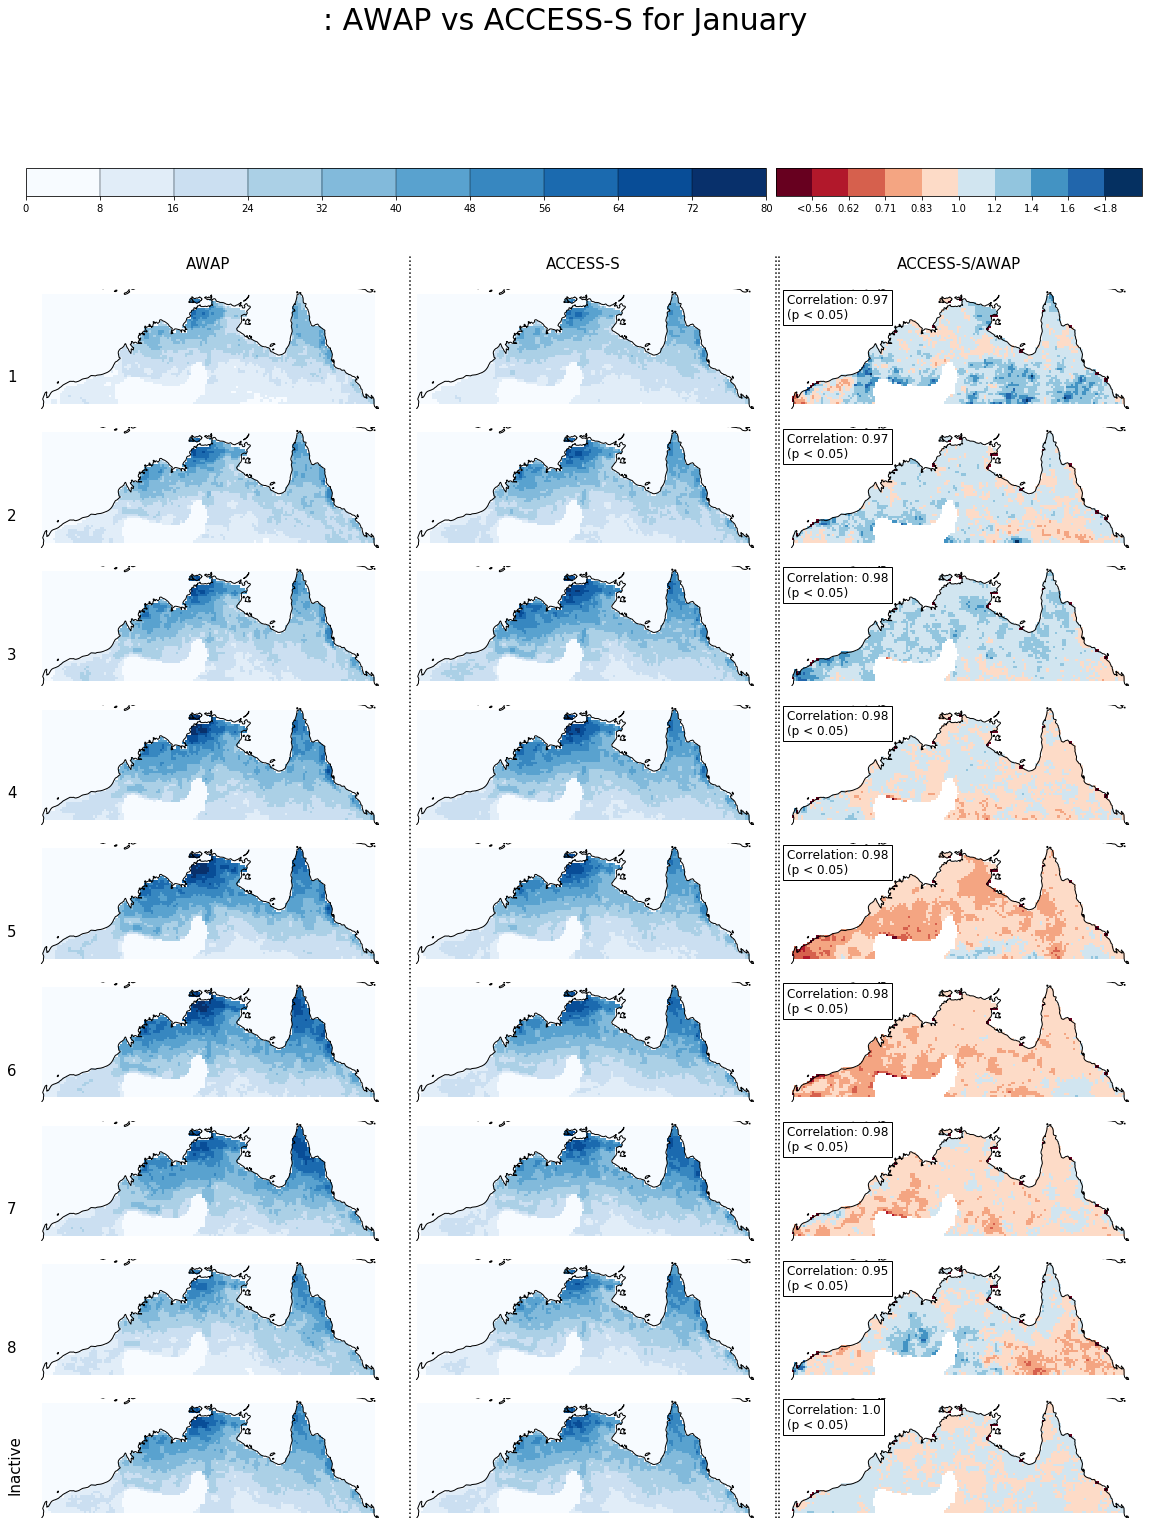

In [31]:
apf = reload(apf)

apf.comparison_plot_phases(awap_count_norm, access_count_mean, month =1,
                          plot_max = 80, vmax = 2,figsize = (20,25))

In [50]:
access_anom_mean

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9)
Coordinates:
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * lat      (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
Data variables:
    precip   (phase, lat, lon) float64 nan 0.5776 0.6053 0.6086 ... nan nan nan

Percent of Days as Raindays Compared
to Climatology: AWAP vs ACCESS-S for January has been saved


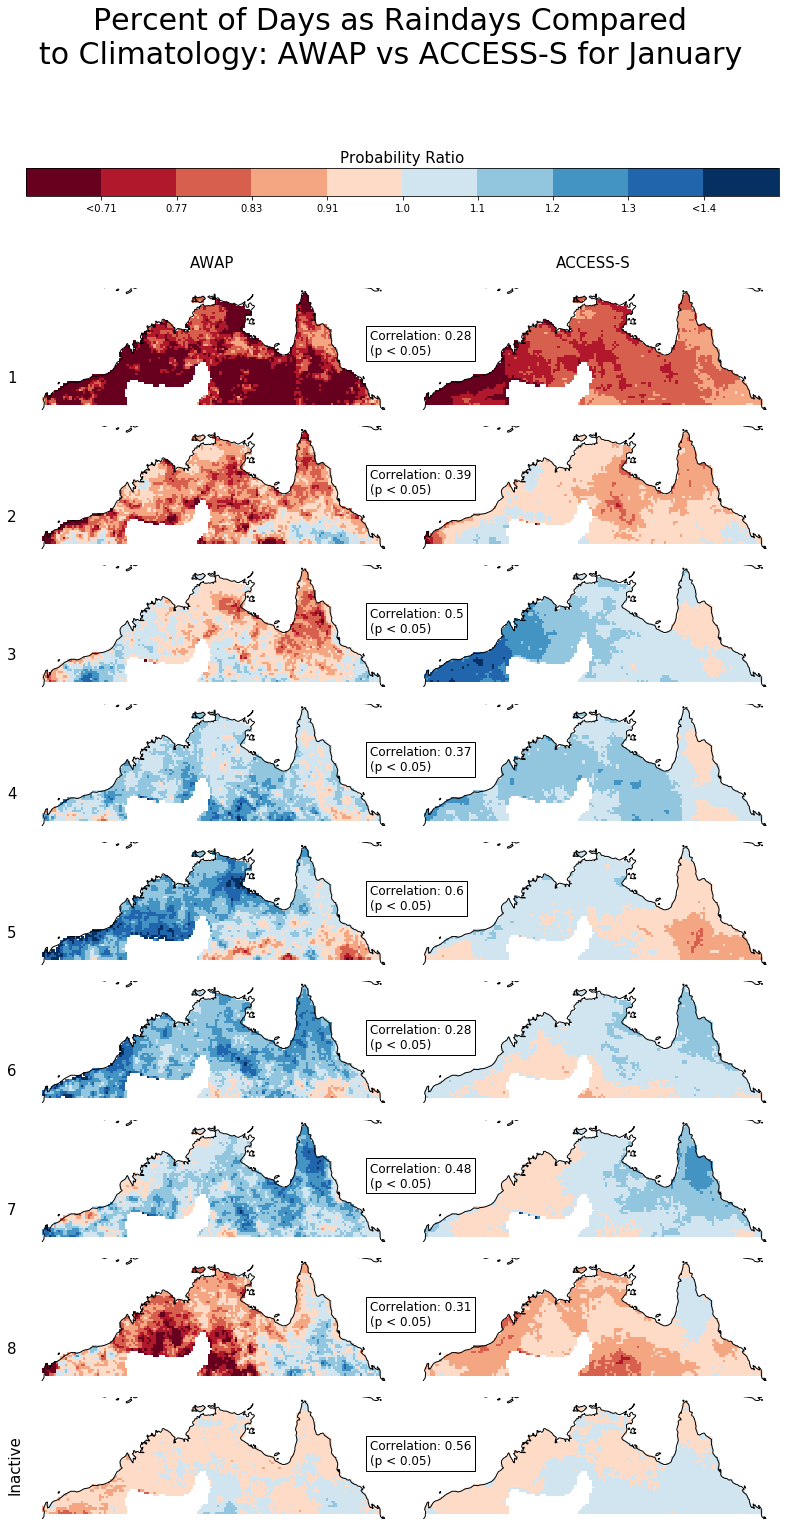

In [112]:
apf = reload(apf)

apf.comparison_plot_phases(awap_count_anomaly, access_anom_mean, month =1,
                           vmax = 1.5,figsize = (13.5,25), add_white = 0 , 
                          cbar_title = 'Probability Ratio', 
                           rain_type = 'Percent of Days as Raindays Compared\nto Climatology',
                          savedir = savedir, savefig = 1)


# Count (Individual Months)

In [15]:
phase_calc = reload(phase_calc)

awap_split = phase_calc.split_into_1to8(awap, rmm)

awap_count_norm, awap_count_anomaly = phase_calc.count_and_anomly_month(awap_split, awap, rmm)

In [16]:
awap_count_norm

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 9)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
  * month    (month) int64 10 11 12 1 2 3
Data variables:
    precip   (month, phase, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

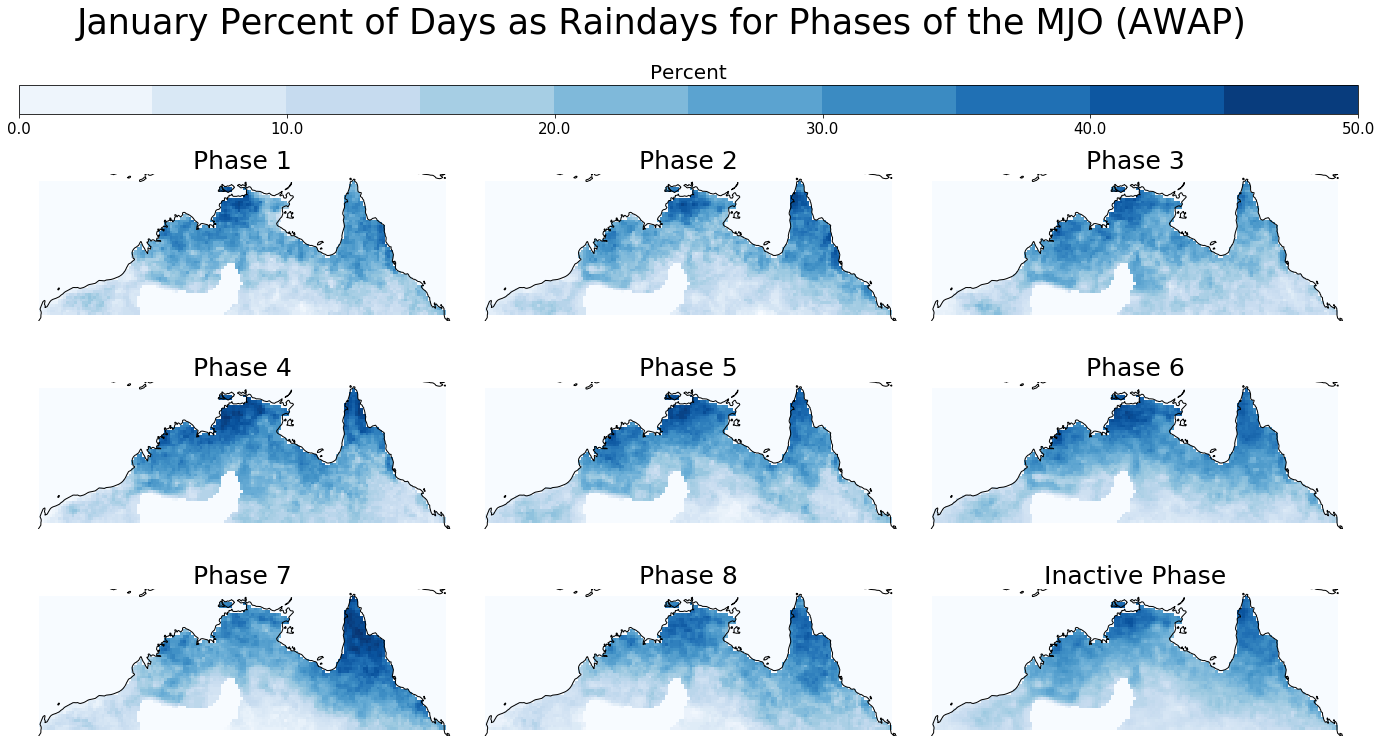

In [20]:
phase_plot = reload(phase_plot)
month = 1


phase_plot.values_plots(awap_count_norm.sel(month = month).precip, cbar_num_steps = 11,
             title = calendar.month_name[month] + ' Percent of Days as Raindays for Phases of the MJO (AWAP) ', cbar_title = 'Percent',
                       savefig = 0,  savedir = savedir)

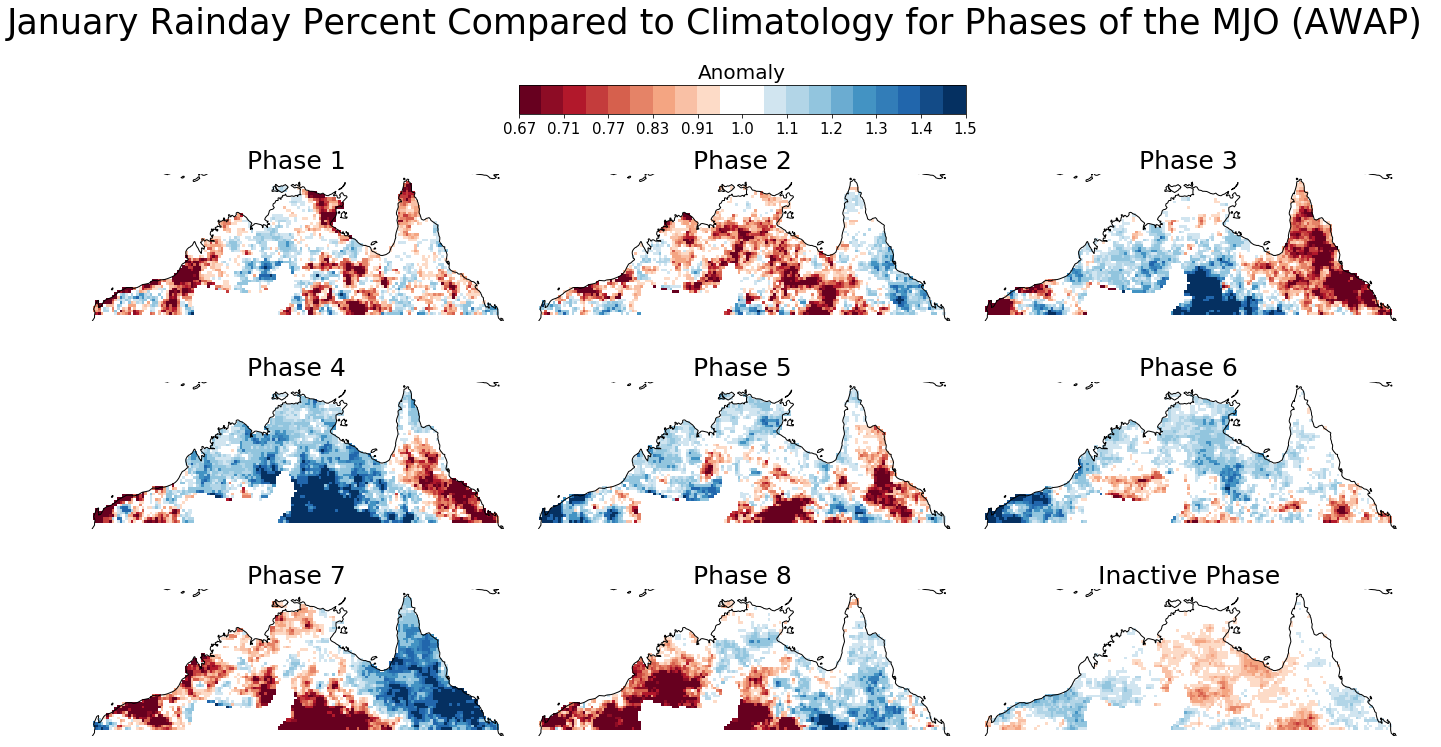

In [21]:
phase_plot = reload(phase_plot)
step = 0.05
end = 1.5
month = 1
l1 = np.arange(1 + step, end + step, step)
phase_plot.anomalies_plots(awap_count_anomaly.sel(month = month).precip, vmax = 1.5, l1 = l1,           
             title = calendar.month_name[month] + ' Rainday Percent Compared to Climatology for Phases of the MJO (AWAP) ', 
                           cbar_title = 'Anomaly',
                       savefig = 0, savedir = savedir)

In [22]:
savedir

'images/access/'

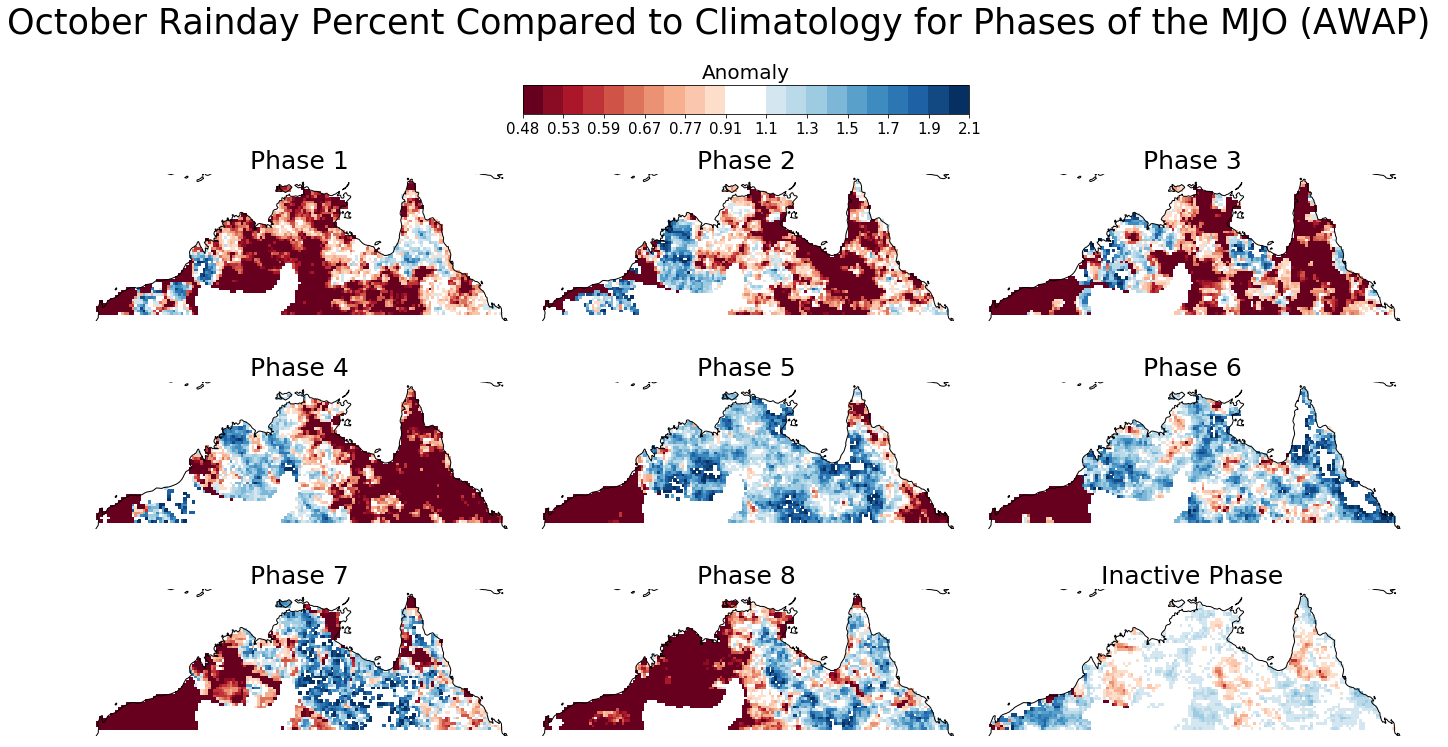

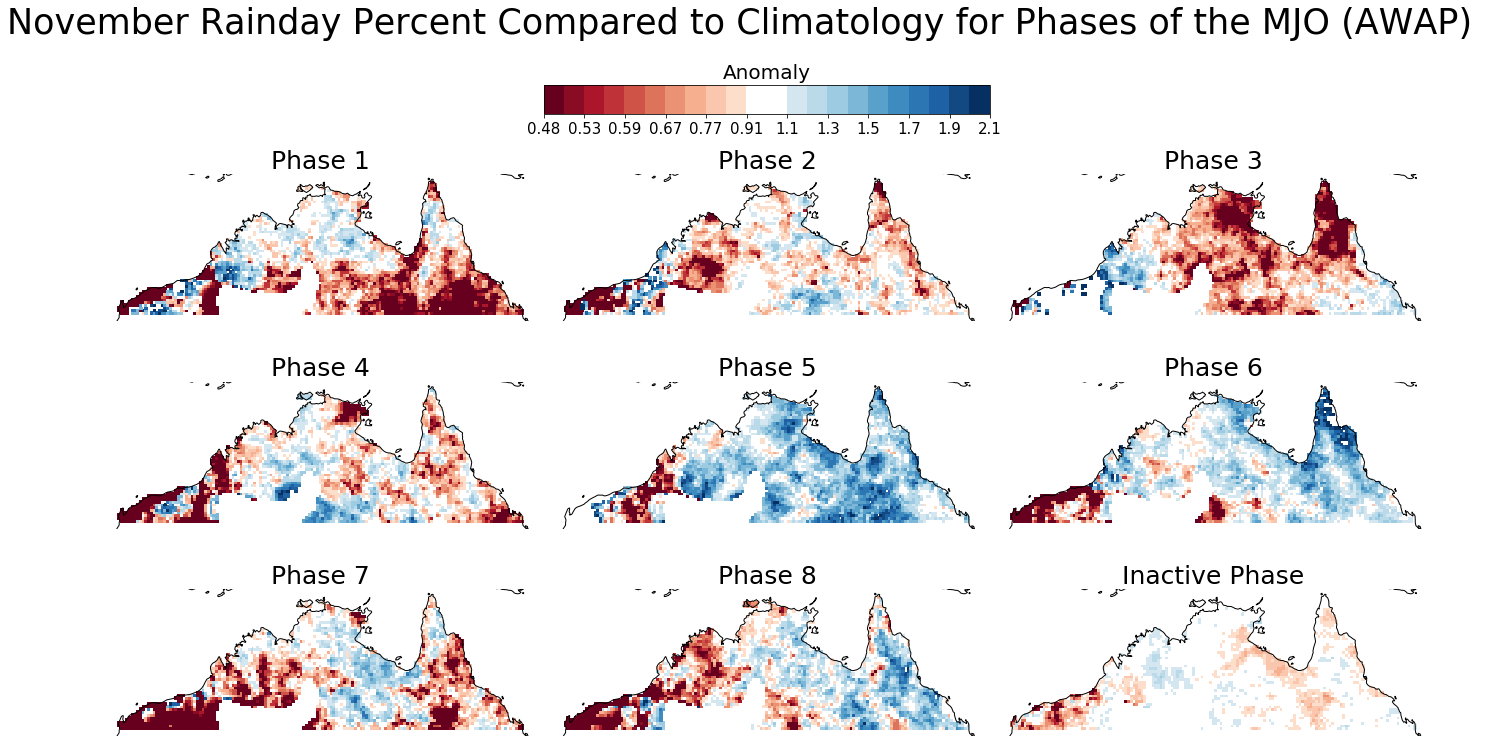

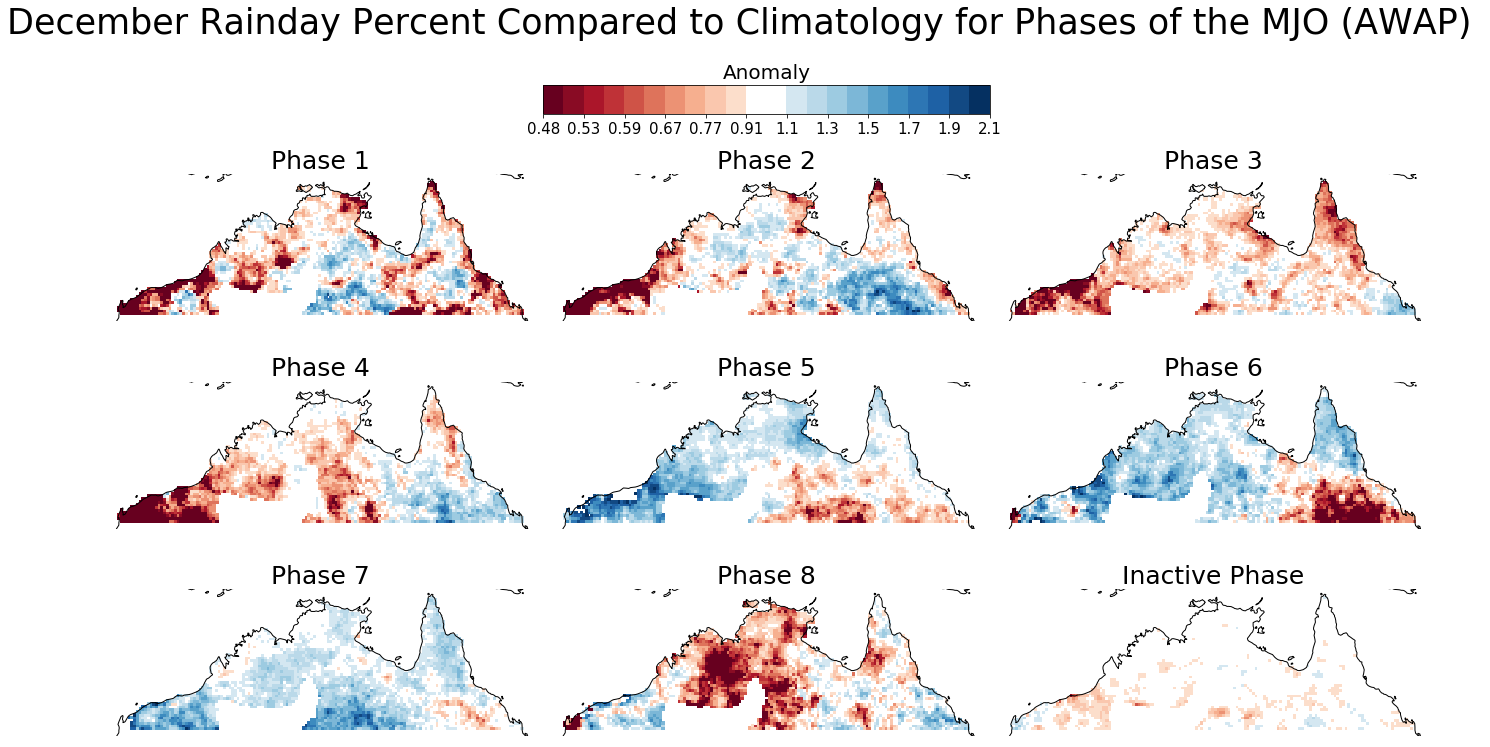

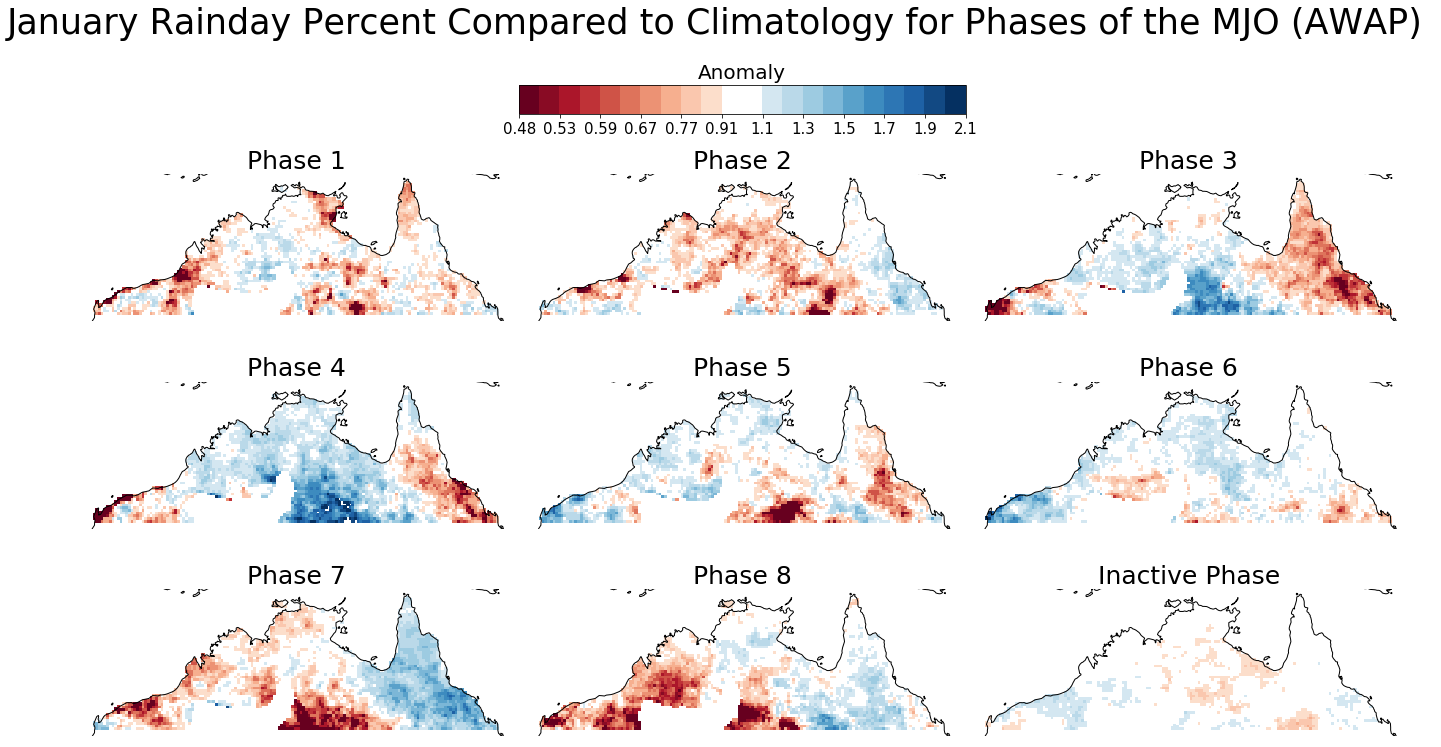

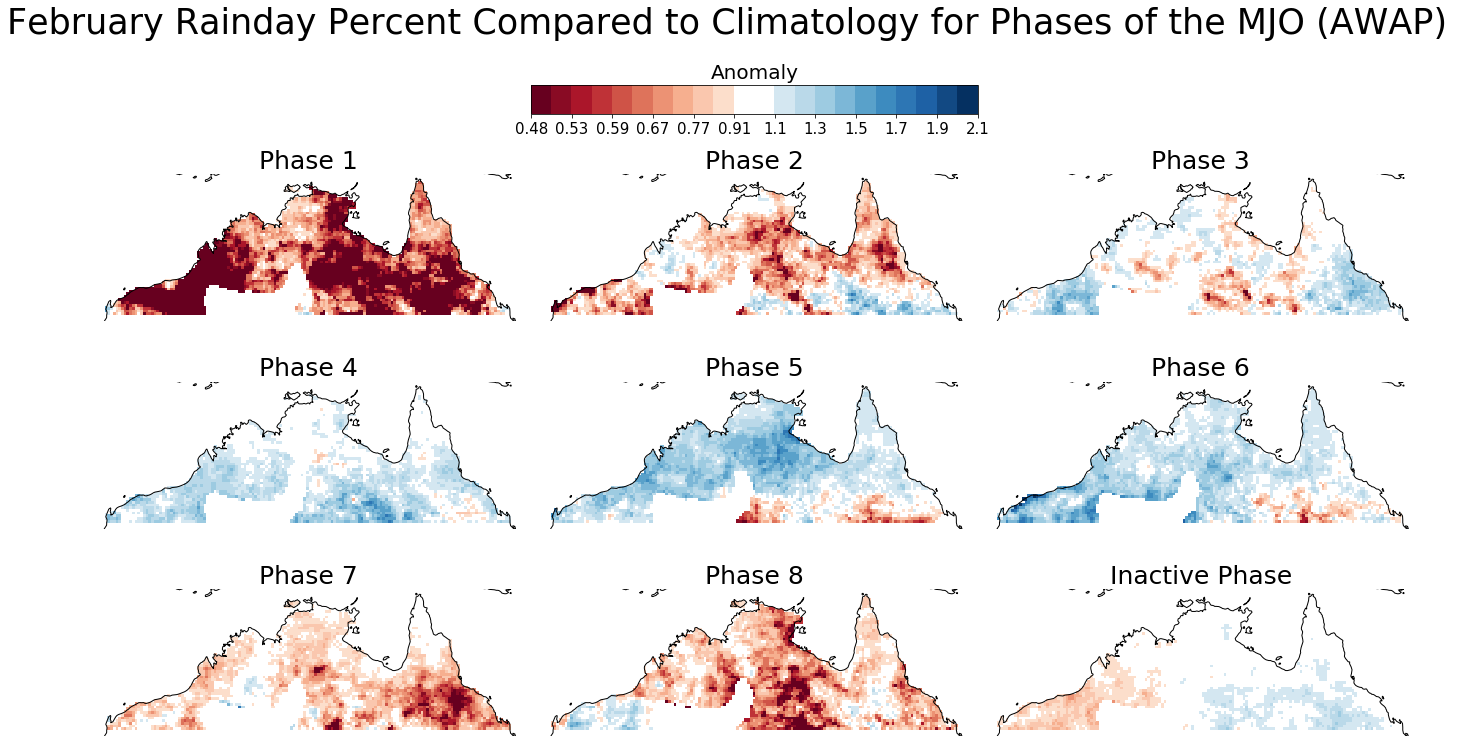

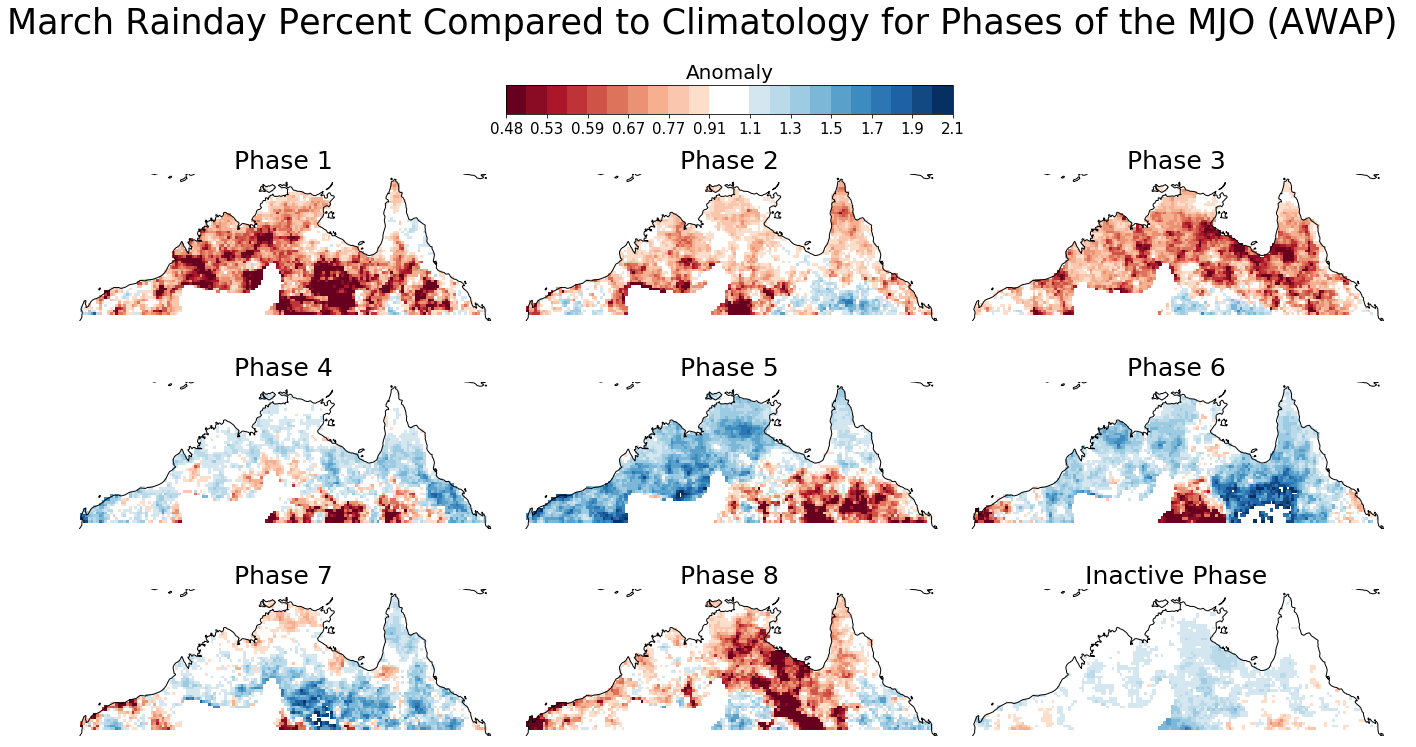

In [30]:
phase_plot = reload(phase_plot)
# step = 0.05
# end = 1.5

# l1 = np.arange(1 + step, end + step, step)
l1 = []

for month in [10,11,12,1,2,3]:
    phase_plot.anomalies_plots(awap_count_anomaly.sel(month = month).precip, vmax = 2.1, l1 = l1,           
                 title = calendar.month_name[month] + ' Rainday Percent Compared to Climatology for Phases of the MJO (AWAP) ', 
                               cbar_title = 'Anomaly',
                           savefig = 1, savedir = savedir, dontplot = 0)